# Dataset obtenido del data hub USFQ 
- Objetivo: Desarrollar una infografia georeferenciada de las votaciones del Ecuador del año del **2002**.
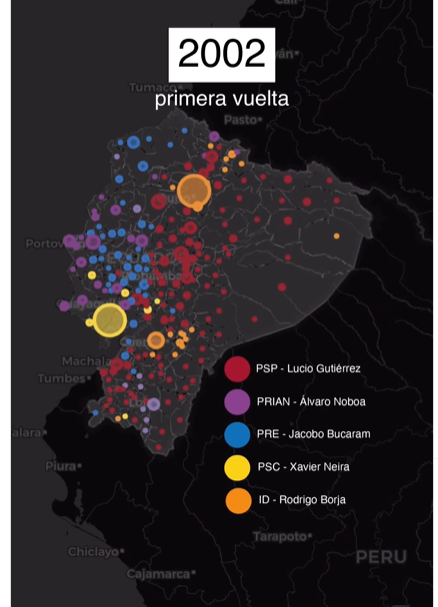

In [1]:
import folium
import pandas as pd
import geopandas as gpd
import branca
import json
from folium.plugins import TimestampedGeoJson

ModuleNotFoundError: No module named 'geopandas'

## Manejo del json con geopandas

In [ ]:
df_ecu = gpd.read_file("ecuador_provincias.json")
df_ecu["name"] = df_ecu["name"].str.upper()
df_ecu.head()

source   id        name  \
0  https://simplemaps.com  ECE  ESMERALDAS   
1  https://simplemaps.com  ECC      CARCHI   
2  https://simplemaps.com  ECU   SUCUMBIOS   
3  https://simplemaps.com  ECD    ORELLANA   
4  https://simplemaps.com  ECY     PASTAZA   

                                            geometry  
0  MULTIPOLYGON (((-78.47812 1.18712, -78.47831 1...  
1  POLYGON ((-78.44211 0.87194, -78.44714 0.87437...  
2  POLYGON ((-77.81408 0.34566, -77.79186 0.37099...  
3  POLYGON ((-77.29941 -0.05855, -77.28401 -0.047...  
4  POLYGON ((-77.05165 -1.01038, -77.07198 -1.033...


## ETL del dataset

**Mendoza, K., Medina, P., & Astudillo, P. (2025).**  
*Ecuadorian Presidential Elections (2002–2023): Canton-Level Results for First and Second Rounds*.  
Harvard Dataverse. https://doi.org/10.7910/DVN/A6ZP75


In [ ]:
df = pd.read_csv("presidentes_votacion_cantonal_formato_angosto.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77462 entries, 0 to 77461
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   ANIO              77462 non-null  int64 
 1   VUELTA            77462 non-null  int64 
 2   PROVINCIA_CODIGO  77462 non-null  object
 3   PROVINCIA_NOMBRE  77462 non-null  object
 4   CANTON_CODIGO     77462 non-null  object
 5   CANTON_NOMBRE     77462 non-null  object
 6   CANDIDATO_NOMBRE  77462 non-null  object
 7   AGRUPACION        77462 non-null  object
 8   VOTOS             77462 non-null  int64 
dtypes: int64(3), object(6)
memory usage: 5.3+ MB


In [ ]:
# agrupacion para obtener valos por provincia
df_gr = df.groupby(["ANIO", "VUELTA", "PROVINCIA_NOMBRE",
        "CANDIDATO_NOMBRE","PROVINCIA_CODIGO"])["VOTOS"].sum().reset_index()
# solo datos de Ecuador continental 
df_gr = df_gr[~df_gr["PROVINCIA_NOMBRE"].isin(['EUROPA, ASIA, '
'OCEANIA', 'NORTE-AMERICA', 'LATAM, CARIBE, AFRICA'])]
# agrupacion por voto mayoritario en provinica
df_max = df_gr.loc[
    df_gr.groupby(['PROVINCIA_NOMBRE','ANIO','VUELTA'])['VOTOS'].idxmax()
]

## Manejo del archivo .json

In [ ]:
# Load Ecuador's GeoJSON data
with open("ecuador_provincias.json", "r", encoding="utf-8") as f:
    geo_json_data = json.load(f)
df_max.PROVINCIA_NOMBRE.unique()

array(['AZUAY', 'BOLIVAR', 'CANAR', 'CARCHI', 'CHIMBORAZO', 'COTOPAXI',
       'EL ORO', 'ESMERALDAS', 'GALAPAGOS', 'GUAYAS', 'IMBABURA', 'LOJA',
       'LOS RIOS', 'MANABI', 'MORONA SANTIAGO', 'NAPO', 'ORELLANA',
       'PASTAZA', 'PICHINCHA', 'SANTA ELENA', 'STO DGO TSACHILAS',
       'SUCUMBIOS', 'TUNGURAHUA', 'ZAMORA CHINCHIPE'], dtype=object)

In [ ]:
# Nombre de la provincias 
nombresGjson = sorted([x['properties']["name"].upper() for x in geo_json_data['features']])
# nombres a cambiar CAÑAR ,'SANTO DOMINGO DE LOS TSÁCHILAS' cambio en el dataset
df_max["PROVINCIA_NOMBRE"] = df_max["PROVINCIA_NOMBRE"].replace({'CANAR':'CAÑAR',
                        'STO DGO TSACHILAS':'SANTO DOMINGO DE LOS TSÁCHILAS'})
df_max["PROVINCIA_NOMBRE"].unique()

array(['AZUAY', 'BOLIVAR', 'CAÑAR', 'CARCHI', 'CHIMBORAZO', 'COTOPAXI',
       'EL ORO', 'ESMERALDAS', 'GALAPAGOS', 'GUAYAS', 'IMBABURA', 'LOJA',
       'LOS RIOS', 'MANABI', 'MORONA SANTIAGO', 'NAPO', 'ORELLANA',
       'PASTAZA', 'PICHINCHA', 'SANTA ELENA',
       'SANTO DOMINGO DE LOS TSÁCHILAS', 'SUCUMBIOS', 'TUNGURAHUA',
       'ZAMORA CHINCHIPE'], dtype=object)

## Estilo del Mapa

In [ ]:
# COLORES POR CANDIDATO
mapa_colores ={'ALVARO NOBOA':"#980BEF", 'JACOBO BUCARAM':"#1070B9", 'LUCIO GUTIERREZ':"#E01212",
       'RODRIGO BORJA':"#FEB00A", 'XAVIER NEIRA':"#F6FE69",'RAFAEL CORREA':"#07F93F",
       'LENIN MORENO':"#07F93F",'YAKU PEREZ':"#F9D107",'GUILLERMO LASSO':"#1070B9",
         'LUISA GONZALEZ':"#34FFF8",'DANIEL NOBOA':"#980BEF", 'NULOS':"#FFFFFF",
       'FERNANDO VILLAVICENCIO':"#96B0FF",'XAVIER HERVAS':"#F9D107", 
       'ANDRES ARAUZ':"#07F93F"
       }
# aplicar color al dataset
df_max['COLOR'] = df_max['CANDIDATO_NOMBRE'].apply(lambda x:mapa_colores.get(x))
df_max.head()

ANIO  VUELTA PROVINCIA_NOMBRE CANDIDATO_NOMBRE PROVINCIA_CODIGO   VOTOS  \
10   2002       1            AZUAY    RODRIGO BORJA             EC01  157246   
290  2002       2            AZUAY  LUCIO GUTIERREZ             EC01  371564   
397  2006       1            AZUAY    RAFAEL CORREA             EC01  166524   
765  2006       2            AZUAY    RAFAEL CORREA             EC01  429830   
879  2009       1            AZUAY    RAFAEL CORREA             EC01  418082   

       COLOR  
10   #FEB00A  
290  #E01212  
397  #07F93F  
765  #07F93F  
879  #07F93F

In [ ]:
def generar_start_end(row, col_anio='ANIO', col_vuelta='VUELTA'):
    """
    Devuelve start y end como timestamps (ms) según:
    - Vuelta 1: del 1 de enero al 1 de julio
    - Vuelta 2: del 2 de julio al 31 diciembre
    """
    anio = int(row[col_anio])
    vuelta = int(row[col_vuelta])

    if vuelta == 1:
        start = pd.Timestamp(f"{anio}-01-01 00:00:00")
        end   = pd.Timestamp(f"{anio}-07-01 00:00:00")
    else:  # vuelta 2
        start = pd.Timestamp(f"{anio}-07-02 00:00:00")
        end   = pd.Timestamp(f"{anio}-12-31 23:59:59")

    # convertir a timestamp en milisegundos
    return {
        'start': float(start.value // 10**6),
        'end':   float(end.value   // 10**6)
    }

In [ ]:
df_max['start_end'] = df_max.apply(lambda x :
generar_start_end(x, col_anio='ANIO', col_vuelta='VUELTA'),
    axis=1
)

In [ ]:
df_merged = df_max.merge(df_ecu[['name', 'geometry']], 
                         left_on='PROVINCIA_NOMBRE', 
                         right_on='name', 
                         how='inner')
# Convertir en GeoDataFrame
gdf_final = gpd.GeoDataFrame(df_merged, geometry='geometry')

## GENERACIÓN DE FEATURES PARA EL TIMELINE 

In [ ]:

features = []

for _, row in gdf_final.iterrows():

    start_ts = int(row['start_end']['start']) // 1000  # segundos UNIX

    start_date = pd.to_datetime(start_ts, unit='s').strftime("%Y-%m-%dT%H:%M:%S")

    feature = {
        "type": "Feature",
        "geometry": row["geometry"].__geo_interface__,
        "properties": {
            "time": start_date,
            "style": {
                "color": "black",
                "weight": 1,
                "opacity": 1,
                "fillColor": row["COLOR"],
                "fillOpacity": 0.8
            },
            "tooltip": f"Provincia: {row['PROVINCIA_NOMBRE']} - {row['CANDIDATO_NOMBRE']}",
            "popup": (
                f"<b>Provincia:</b> {row['PROVINCIA_NOMBRE']}<br>"
                f"<b>Candidato:</b> {row['CANDIDATO_NOMBRE']}<br>"
                f"<b>Votos:</b> {row['VOTOS']}<br>"
                f"<b>Año:</b> {row['ANIO']} - Vuelta {row['VUELTA']}"
            )
        }
    }
    features.append(feature)
features[0]

{'type': 'Feature',
 'geometry': {'type': 'Polygon',
  'coordinates': (((-78.54910172896793, -2.5629438871396006),
    (-78.55527706351482, -2.592657887280626),
    (-78.55403682999633, -2.602269738154065),
    (-78.55026445093884, -2.612501669684764),
    (-78.5427713724291, -2.619633197986528),
    (-78.53331457855316, -2.6239220891356574),
    (-78.52636410042774, -2.622836948001352),
    (-78.52204911858809, -2.617462615292379),
    (-78.5198787100717, -2.6066106031091656),
    (-78.51615800676939, -2.595965284487299),
    (-78.51026689417145, -2.5852166191031682),
    (-78.4997507383888, -2.576276522279215),
    (-78.49052649576058, -2.5710572097579876),
    (-78.48070797070773, -2.5681115262693397),
    (-78.47210385161748, -2.5682668468571297),
    (-78.46592851365568, -2.5709021895968056),
    (-78.43458676095891, -2.5944150828715213),
    (-78.42784298403495, -2.6014946373456227),
    (-78.42391557631156, -2.6104347341935066),
    (-78.4213575881105, -2.6184960830387456),
    

### CREAR MAPA BASE

In [ ]:
m = folium.Map(
    location=[-0.19899731681836336, -78.4428000494774],
    tiles="Cartodb dark_matter", ## estilo del fondo mapa
    zoom_start=6
)

### AÑADIR CAPA TEMPORAL

In [ ]:
ts = TimestampedGeoJson(
    {
        "type": "FeatureCollection",
        "features": features,
    },
    period="P1Y",
    duration="P1Y",
    add_last_point=True,
    auto_play=False,
    loop=False
).add_to(m)

## LEYENDA ( CANDIDATO Y COLOR ) y VISUALIZACION FINAL

In [ ]:
items_html = ""
for candidato, color in mapa_colores.items():
    items_html += f'''
    &nbsp; <i class="fa fa-square" style="color:{color};"></i>
    &nbsp; {candidato}<br>'''

legend_html = f"""
{{% macro html(this, kwargs) %}}
<div style="
     position: fixed;
     bottom: 50px; left: 50px;
     width: 250px;
     border:2px solid grey;
     z-index:9999;
     font-size:14px;
     background-color:white;
     opacity: 0.9;
     padding: 10px;
     border-radius: 5px;">
     <b>🗳️ Candidato ganador</b><br>
     {items_html}
</div>
{{% endmacro %}}
"""

legend = branca.element.MacroElement()
legend._template = branca.element.Template(legend_html)
m.get_root().add_child(legend)

m.save("VotEcuador_Timeline_Legend.html")
m
